In [1]:
%load_ext autoreload
%autoreload 2
from train import *

In [2]:
model_kwargs = {'dim_z': 6, 'rank': 6, 'dim_hid': 50, 'alpha': 0.5} 
epochs = 15 
seed = 0 
n_trials = 2560 
batch_size = 64
save_dir = None
set_deterministic(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CXTRNN(**model_kwargs).to(device)
print(get_n_params(model), flush=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
##################
multitask_dataset = MultiTaskDataset(n_trials=n_trials)
n_trials_tr = int(0.8 * n_trials)
tr_data_loader = DataLoader(dataset=multitask_dataset[:n_trials_tr], batch_size=batch_size, collate_fn=collate_fn)
ts_data_loader = DataLoader(dataset=multitask_dataset[n_trials_tr:], batch_size=batch_size, collate_fn=collate_fn)
tr_loss_arr = []
ts_loss_arr = []
##################
for epoch in range(epochs):
    ######################
    model.train()
    avg_tr_loss = []
    for ib, cur_batch in enumerate(tr_data_loader):
        syz, lengths = cur_batch
        syz = syz.to(device)
        s, y, z = syz[..., :3], syz[..., 3:6], syz[..., -1]
        z = F.one_hot(z.to(torch.int64), num_classes=6).float()
        out = model(s, z)
        loss = masked_mse_loss(out, y, lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_tr_loss.append(loss.item())
        if ib % 10 == 0:
            print(f'epoch {epoch}, batch {ib}, train loss: {loss.item():.4f}', flush=True)
    tr_loss_arr.append(np.mean(avg_tr_loss))
    scheduler.step()
    #######################
    model.eval()
    with torch.no_grad():
        avg_ts_loss = []
        for ib, cur_batch in enumerate(ts_data_loader):
            syz, lengths = cur_batch
            syz = syz.to(device)
            s, y, z = syz[..., :3], syz[..., 3:6], syz[..., -1]
            z = F.one_hot(z.to(torch.int64), num_classes=6).float()
            out = model(s, z)
            loss = masked_mse_loss(out, y, lengths)
            avg_ts_loss.append(loss.item())
            print(f'epoch {epoch} test, batch {ib}, test loss: {loss.item():.4f}', flush=True)
        ts_loss_arr.append(np.mean(avg_ts_loss))
    ########################
if save_dir is not None:
    torch.save(model.state_dict(), save_dir + '/model.pth')
    np.save(save_dir + '/tr_loss.npy', np.array(tr_loss_arr).astype(float))
    np.save(save_dir + '/ts_loss.npy', np.array(ts_loss_arr).astype(float)) 

995
epoch 0, batch 0, train loss: 0.3211
epoch 0, batch 10, train loss: 0.0669
epoch 0, batch 20, train loss: 0.0621
epoch 0, batch 30, train loss: 0.0522
epoch 0 test, batch 0, test loss: 0.0590
epoch 0 test, batch 1, test loss: 0.0505
epoch 0 test, batch 2, test loss: 0.0449
epoch 0 test, batch 3, test loss: 0.0511
epoch 0 test, batch 4, test loss: 0.0586
epoch 0 test, batch 5, test loss: 0.0574
epoch 0 test, batch 6, test loss: 0.0520
epoch 0 test, batch 7, test loss: 0.0546
epoch 1, batch 0, train loss: 0.0587
epoch 1, batch 10, train loss: 0.0500
epoch 1, batch 20, train loss: 0.0526
epoch 1, batch 30, train loss: 0.0488
epoch 1 test, batch 0, test loss: 0.0508
epoch 1 test, batch 1, test loss: 0.0450
epoch 1 test, batch 2, test loss: 0.0423
epoch 1 test, batch 3, test loss: 0.0476
epoch 1 test, batch 4, test loss: 0.0520
epoch 1 test, batch 5, test loss: 0.0505
epoch 1 test, batch 6, test loss: 0.0414
epoch 1 test, batch 7, test loss: 0.0470
epoch 2, batch 0, train loss: 0.0535
e

[0. 1. 2.]
[0. 1. 4.]
[0. 1. 5.]
[0. 1. 4.]
[0. 1. 3.]
[0. 1. 4.]
[0. 1. 5.]
[0. 1. 4.]
[0. 1. 4.]
[0. 1. 3.]
[0. 1. 2.]
[0. 1. 3.]
[0. 1. 4.]
[0. 1. 4.]
[0. 1. 4.]


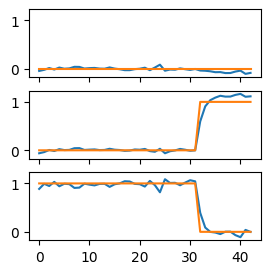

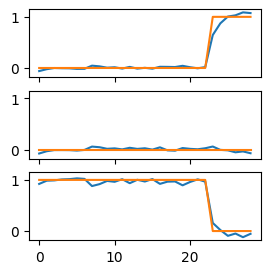

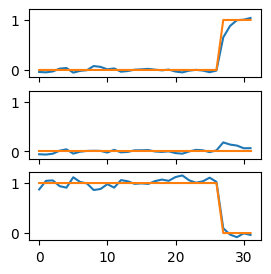

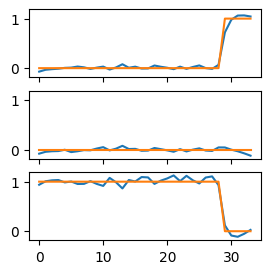

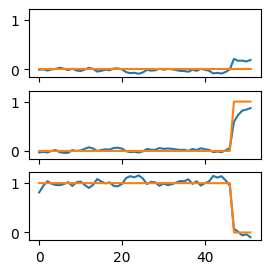

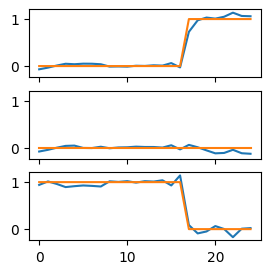

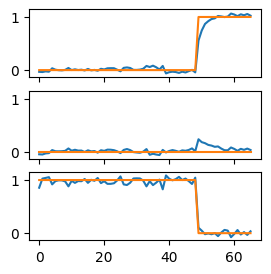

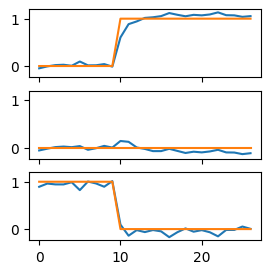

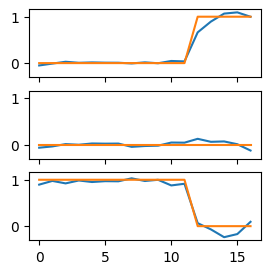

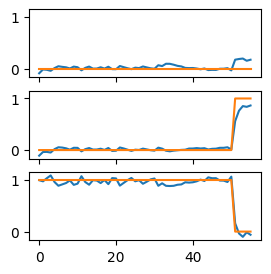

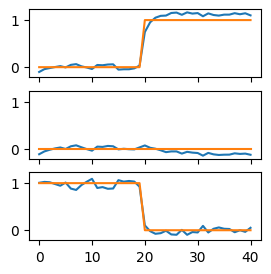

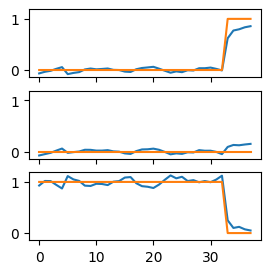

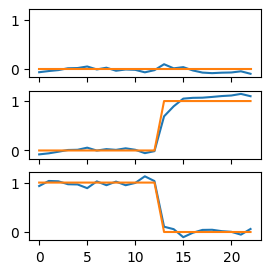

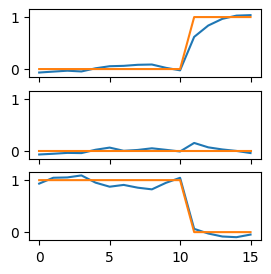

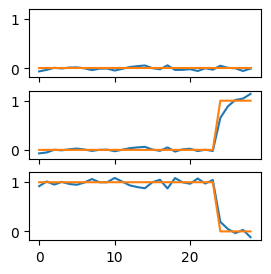

In [3]:
for itrial in range(15):
    length = lengths[itrial]
    print(np.unique(syz[:length, itrial, -1].cpu().numpy()))
    fig, axes = plt.subplots(3, 1, figsize=(3, 3), sharey=True, sharex=True)
    for iax in range(3):
        axes[iax].plot(out[:length, itrial, iax].cpu().numpy())
        axes[iax].plot(y[:length, itrial, iax].cpu().numpy())

[0.43685988 0.53886425 0.4903186  0.39045164 0.40298444 0.46961832]
[0.42955533 0.43042457 0.5057869  0.39044443 0.42727616 0.44978166]
[0.5056486  0.37800607 0.5169338  0.60448384 0.36457613 0.3357828 ]
[0.5092797  0.5601892  0.61289346 0.53590167 0.3932866  0.351622  ]
[0.55815494 0.54454947 0.5915047  0.26290703 0.2998265  0.6266335 ]
[0.65049046 0.5187355  0.64036065 0.29121625 0.39537463 0.7011128 ]


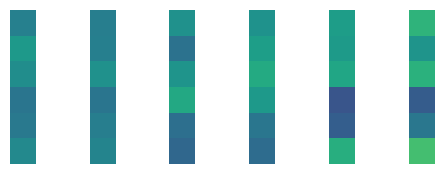

In [4]:
fig, axes = plt.subplots(1, 6, figsize=(6, 2))
for iz in range(6):
    z_t = torch.zeros(6, device=device)
    z_t[iz] = 1
    gating = torch.sigmoid(model.nm_layer(z_t)).detach().cpu().numpy()
    print(gating)
    axes[iz].imshow(gating[:, None], vmin=0, vmax=1)
    axes[iz].axis('off')

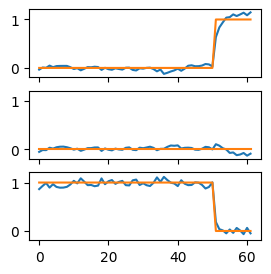

In [33]:
epoch_str = 'F/D->S->F/D->R_P'
x = np.random.choice([0, 1])
sig_s = 0.05 
sig_y = 0 
p_stay = 0.9
min_Te = 5
z_list=['F/D', 'S', 'R_P', 'R_M_P', 'R_A', 'R_M_A']
sy, boundaries = compose_trial(epoch_str, {'theta_task': x}, sig_s, sig_y, p_stay, min_Te)
all_Te = np.diff([0] + list(boundaries))
z = [[z_list.index(cur)] * Te for cur, Te in zip(epoch_str.split('->'), all_Te)]
z = np.array([j for i in z for j in i])[:, None]
syz = np.concatenate([sy['s'], sy['y'], z], axis=-1)
syz = torch.tensor(syz[:, None, :], dtype=torch.float32)
syz = syz.to(device)
s, y, z = syz[..., :3], syz[..., 3:6], syz[..., -1]
z = F.one_hot(z.to(torch.int64), num_classes=6).float()
with torch.no_grad():
    out = model(s, z)
fig, axes = plt.subplots(3, 1, figsize=(3, 3), sharey=True, sharex=True)
for iax in range(3):
    axes[iax].plot(out[:, :, iax].cpu().numpy())
    axes[iax].plot(y[:, :, iax].cpu().numpy())